In [ ]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import torch

import sys
sys.path.append('../../code')

from rnaseqTools import geneSelection

### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [2]:
V1_25degree = pickle.load(open('../../code/pickles/V1_features.pickle', 'rb'))
ephys_features = np.array(V1_25degree['X_o'].columns)[:-1]
Xo = V1_25degree['X_o'].copy()
V1_names = V1_25degree['V1_names']
feature_list = range(23)

In [3]:
v1_meta = pd.read_csv('../../data/Gouwens (2020)/20200625_patchseq_metadata_mouse.csv')
v1_meta = v1_meta.set_index('ephys_session_id')
v1_meta = v1_meta.reindex(Xo.index.astype('int64'))
celltypes = v1_meta['corresponding_AIT2.3.1_alias']
v1_meta.shape

(4107, 21)

In [4]:
celltype_Vip, celltype_Sst, celltype_Lamp5, celltype_Pvalb, celltype_Sncg, celltype_Serpinf1 = \
    [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0], \
        [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0]

for i, ct in enumerate(celltypes):
    if isinstance(ct, str):
        if ct.split(' ')[0]=='Vip':
            celltype_Vip[i]=True
        elif ct.split(' ')[0]=='Sst':
            celltype_Sst[i]=True
        elif ct.split(' ')[0]=='Lamp5':
            celltype_Lamp5[i]=True
        elif ct.split(' ')[0]=='Pvalb':
            celltype_Pvalb[i]=True
        elif ct.split(' ')[0]=='Sncg':
            celltype_Sncg[i]=True
        elif ct.split(' ')[0]=='Serpinf1':
            celltype_Serpinf1[i]=True

In [5]:
ttypes_tasic = np.load('../../data/Gouwens (2020)/tasic-ttypes.npy')
colors_tasic = np.load('../../data/Gouwens (2020)/tasic-colors.npy')
color_map = {}
for c_type in np.unique(ttypes_tasic):
    color_map.update({c_type:colors_tasic[np.where(ttypes_tasic==c_type)[0][0]]})
colors = np.array([
    color_map[c_type] if c_type in ttypes_tasic else 'black' for c_type in celltypes
])

In [6]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', 'rate_to_SS_factor', 'I'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1,   20]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3,   870]

### Figure 5

t-SNE overlayed with fitted model parameters, fitted electrophysiology, true electrophysiology and marker genes

We load 2 neural density networks trained in `../code/build_amortized_posteriors.ipynb` with 2 different training schedules: one without and one with noise introduced to summary statistics of simulations, termed **NPE** and **NPE-N**, respectively. 

In [7]:
with open("../../code/save_posteriors/V1/training_schedule_0.pickle", "rb") as f:
    npe_posterior = pickle.load(f)
with open("../../code/save_posteriors/V1/training_schedule_2d.pickle", "rb") as f:
    npep_posterior = pickle.load(f)

/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let us get the gene expression levels for the same cells.

In [8]:
v1_genes = pd.read_csv('../../data/Gouwens (2020)/20200513_Mouse_PatchSeq_Release_count.csv')
v1_genes=v1_genes.set_index('Unnamed: 0').T
v1_genes=v1_genes.reindex(v1_meta['transcriptomics_sample_id'].values)
gene_names = v1_genes.columns.values
v1_genes.shape

(4107, 45768)

Select 1000 most variable genes.

In [9]:
exonCounts = v1_genes.values
non_nans = ~np.isnan(exonCounts.sum(axis=1))
exonCounts = exonCounts[non_nans,:]
exonCounts.shape

(3559, 45768)

Chosen offset: 6.37


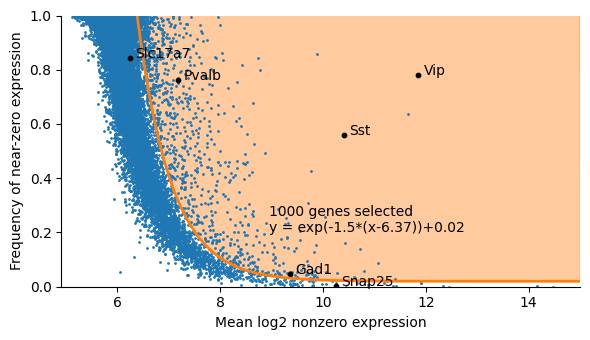

In [10]:
amount_of_genes = 1000
markerGenes = ["Snap25", "Gad1", "Slc17a7", "Pvalb", "Sst", "Vip"]
selectedGenes = geneSelection(
    exonCounts, n=amount_of_genes, threshold=30, markers=markerGenes, genes=gene_names
)
exonCounts = exonCounts[:, selectedGenes]
gene_names = gene_names[selectedGenes]

Further preprocessing for genes (library size normalization and Z-scoring).

In [11]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

In [16]:
# load T-sne embedding coordinates
Z = np.load("./embedding_coordinates/tsne.npz")["coord"]

In [17]:
fav_tr_schedule = "2d"

##### Fetch highest posterior samples

In [18]:
with open(
    "../../code/save_model_parameters/V1/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((14,)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

Fetch random samples with evaluations from the neural density network built with our favourite training schedule (**NPE-N**) and computed in `../code/build_amortized_posteriors.ipynb`.

In [19]:
with open(
    "../../code/save_model_parameters/V1/favourite_training_schedule.pickle", "rb"
) as f:
    fav_training_schedule = pickle.load(f)

In [20]:
len(fav_training_schedule['samples'])

4106

In [21]:
fav_training_schedule['samples']['645441106'].shape

(1000, 14)

In [22]:
with open(
    "../../code/save_model_parameters/V1/favourite_training_schedule.pickle", "rb"
) as f:
    fav_training_schedule = pickle.load(f)
samples = np.concatenate(
    [fav_training_schedule["samples"][cell] if cell in fav_training_schedule["samples"] else np.ones((1000,14))*np.nan for cell in Xo.index]
).reshape((Xo.shape[0], 1000, len(model_param_names)))
samples = torch.as_tensor(samples, dtype=torch.float32)

In [23]:
for cell in Xo.index:
    if cell not in fav_training_schedule["samples"]:
        print(cell)

759901388


The following result should be pretty high in comparison to next block's values

In [24]:
npep_posterior.log_prob(
    highest_posterior_samples[0, :], x=Xo.iloc[0, :].values[feature_list]
)

tensor([-38.2340])

In [25]:
npep_posterior.log_prob(samples[0, :, :], x=Xo.iloc[0, :].values[feature_list])[:10]

tensor([-41.5709, -40.1609, -42.0132, -42.6481, -43.0806, -46.7688, -43.7262,
        -52.2074, -46.6415, -45.8012])

In [ ]:
## uncomment to recompute
uncertainty=np.zeros((Xo.shape[0]))
for i in range(3735,Xo.shape[0]):
    if i%100==0:
        print(i, end='')
    print('.', end='')
    if i!=409:
        uncertainty[i]=torch.mean(-npep_posterior.log_prob(samples[i,:,:],x=Xo.iloc[i,:].values[feature_list])).item()
    else:
        uncertainty[i]=np.nan
np.savez('../../code/save_uncertainty/npep_entropy_V1.npz',
     entropy=uncertainty
        )

In [40]:
uncertainty = np.load("../../code/save_uncertainty/npep_entropy_V1.npz")["entropy"]

We load the summary statistics of simulations generated with maximum-a-posteriori estimates derived with **NPE-N** for each experimental observation. Simulations and derived summary statistics were computed in `../code/report_performances.ipynb`.

In [43]:
MAP_stats = np.load(
    "../../code/save_sims/highest_posterior_samples_summ_stats_{}_V1.npz".format(
        fav_tr_schedule
    )
)["stats"]
MAP_stats = MAP_stats

In [44]:
def create_figure_5(fig):
    if fig is None:
        fig = plt.figure(figsize=(14, 10))
    else:
        fig = fig

    width, height = 0.14, 0.12
    w_scale, h_scale = width * 1.2, height * 1.2
    ax_latent = plt.axes([0, 0.6, (w_scale - 0.02) * 2, h_scale * 2])
    axes_marker_genes = np.array(
        [
            [plt.axes([x, y, width, height]) for x in [0.167 * 2, 0.167 * 3]]
            for y in [0.6 + h_scale, 0.6]
        ]
    )
    ax_HH_uncertainty = plt.axes([w_scale * 4, 0.6, w_scale * 2, h_scale * 2])
    axes_fitted_ephys = np.array(
        [
            plt.axes([x, 0.4, width, height])
            for x in [0, w_scale, w_scale * 2, w_scale * 3, w_scale * 4, w_scale * 5]
        ]
    )
    axes_true_ephys = np.array(
        [
            plt.axes([x, 0.2, width, height])
            for x in [0, w_scale, w_scale * 2, w_scale * 3, w_scale * 4, w_scale * 5]
        ]
    )
    axes_params = np.array(
        [
            plt.axes([x, 0, width, height])
            for x in [0, w_scale, w_scale * 2, w_scale * 3, w_scale * 4, w_scale * 5]
        ]
    )

    return (
        ax_latent,
        axes_marker_genes,
        ax_HH_uncertainty,
        axes_fitted_ephys,
        axes_true_ephys,
        axes_params,
    )

In [45]:
import matplotlib.tri as tri
def latent_space_overlays(
    Z,
    X,
    X_column_index,
    geneNames,
    alpha=1,
    triangle_max_len=50,
    fontsize=14,
    axis=None,
):
    """
    Parameters
    ----------
    Z: latent space coordinates (2D numpy array)
    X: normalized overlaying data (2D numpy array)
    X_column_index: column index in X, correspoding to certain feature
    names: list of feature names (X_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)

    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    """

    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    # produces triangles from latent coordinates
    triang = tri.Triangulation(Z[:, 0], Z[:, 1])

    # extract coordinates of each triangle
    x1 = Z[:, 0][triang.triangles][:, 0]
    x2 = Z[:, 0][triang.triangles][:, 1]
    x3 = Z[:, 0][triang.triangles][:, 2]
    y1 = Z[:, 1][triang.triangles][:, 0]
    y2 = Z[:, 1][triang.triangles][:, 1]
    y3 = Z[:, 1][triang.triangles][:, 2]

    # calculate edges
    edges = np.concatenate(
        (
            np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)[:, np.newaxis],
        ),
        axis=1,
    )

    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)
        > np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-triangle_max_len]
    )
    ax.tricontourf(
        triang,
        X[:, X_column_index],
        cmap="inferno",
        levels=np.linspace(-2, 2, 5),
        extend="both",
    )
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    ax.set_title(geneNames[X_column_index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    return ax

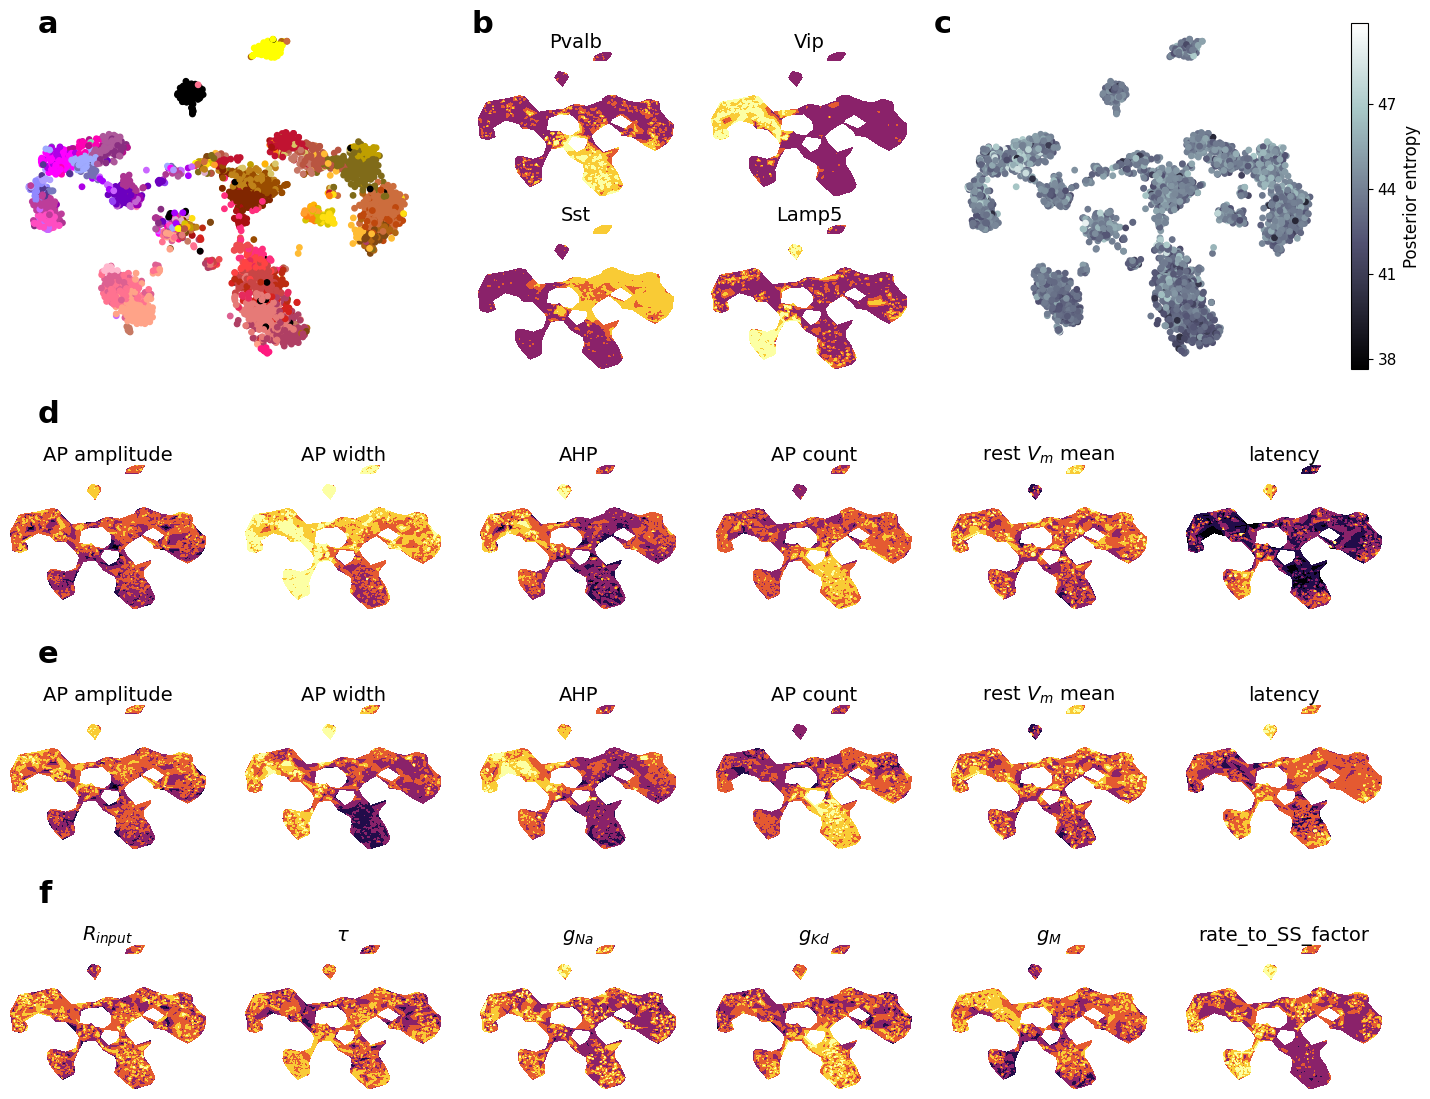

In [63]:
fig = plt.figure(figsize=(14, 12))
(
    ax_latent,
    axes_marker_genes,
    ax_HH_uncertainty,
    axes_fitted_ephys,
    axes_true_ephys,
    axes_params,
) = create_figure_5(fig)

# t-SNE latent
ax_latent.scatter(Z[:, 0], Z[:, 1], s=15, c=colors[non_nans])
ax_latent.set_xticks([])
ax_latent.set_yticks([])
sns.despine(ax=ax_latent, left=True, bottom=True)

# uncertainty of fitted model parameters
scatter = ax_HH_uncertainty.scatter(Z[:, 0], Z[:, 1], s=15, c=uncertainty[non_nans], cmap="bone")
cbar = plt.colorbar(
    scatter, ax=ax_HH_uncertainty, ticks=[38,41,44,47]
)  # , anchor=(,.5))
cbar.ax.tick_params(labelsize=11)
cbar.set_label("Posterior entropy", fontsize=12)
ax_HH_uncertainty.set_xticks([])
ax_HH_uncertainty.set_yticks([])
sns.despine(ax=ax_HH_uncertainty, left=True, bottom=True)

# marker genes
marker_gene_ids = [
    np.where(gene_names == "Pvalb")[0][0],
    np.where(gene_names == "Vip")[0][0],
    np.where(gene_names == "Sst")[0][0],
    np.where(gene_names == "Lamp5")[0][0],
]
for i, ax in enumerate(axes_marker_genes.reshape(-1)):
    latent_space_overlays(
        Z, G, marker_gene_ids[i], gene_names, triangle_max_len=150, axis=ax
    )
    sns.despine(ax=ax, bottom=True, left=True)

# model params
model_param_ids_to_show = [1, 2, 4, 5, 6, -2]
for i, ax in enumerate(axes_params):
    latent_space_overlays(
        Z,
        (highest_posterior_samples[non_nans] - highest_posterior_samples.mean(axis=0))
        / highest_posterior_samples.std(axis=0),
        model_param_ids_to_show[i],
        model_param_names,
        triangle_max_len=150,
        axis=ax,
    )
    sns.despine(ax=ax, bottom=True, left=True)

ephys_feature_ids_to_show = [1, 2, 3, 8, 19, 18]
for i, ax in enumerate(axes_fitted_ephys.reshape(-1)):
    latent_space_overlays(
        Z[~np.isnan(MAP_stats.mean(axis=1))[non_nans], :],
        (MAP_stats[non_nans,:][~np.isnan(MAP_stats.mean(axis=1))[non_nans], :] - Xo.values.mean(axis=0)[:-1])
        / Xo.values.std(axis=0)[:-1],
        ephys_feature_ids_to_show[i],
        ephys_features,
        triangle_max_len=150,
        axis=ax,
    )
    sns.despine(ax=ax, bottom=True, left=True)

for i, ax in enumerate(axes_true_ephys.reshape(-1)):
    latent_space_overlays(
        Z,
        (Xo.values[non_nans, :-1] - Xo.values.mean(axis=0)[:-1]) / Xo.values.std(axis=0)[:-1],
        ephys_feature_ids_to_show[i],
        ephys_features,
        triangle_max_len=150,
        axis=ax,
    )
    sns.despine(ax=ax, bottom=True, left=True)

shift = 0.02
fig.text(0 + shift, 0.88, "a", fontsize=22, fontweight="bold")
fig.text(0.33, 0.88, "b", fontsize=22, fontweight="bold")
fig.text(0.66, 0.88, "c", fontsize=22, fontweight="bold")
fig.text(0 + shift, 0.555, "d", fontsize=22, fontweight="bold")
fig.text(0 + shift, 0.355, "e", fontsize=22, fontweight="bold")
fig.text(0 + shift, 0.155, "f", fontsize=22, fontweight="bold")

plt.savefig("figure_5_V1.png", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_5_V1.pdf", bbox_inches="tight", pad_inches=0)